In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import deque

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:

root = "~/data/MNIST"

# load the dataset and pre-process
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset = datasets.MNIST(root, train=True, download=True,
                transform=transform)
test_data = datasets.MNIST(root, train=False,
                transform=transform)

train_dataset, _ = random_split(dataset, [10000, len(dataset) - 10000])



In [4]:
class LBFGS():
    def __init__(self, params, lr = 0.01 , max_iter=100, memory_size=10, line_search_fn=None):
        self.max_iter = max_iter
        self.memory_size = memory_size
        self.line_search_fn = line_search_fn
        self.s = deque(maxlen=memory_size)
        self.y = deque(maxlen=memory_size)
        self.rho = deque(maxlen=memory_size)
        self._params = list(params)
        self.last_s = None
        self.last_grad = None
        self.lr = lr
    
    def update_memory(self, s, y):
        ys = torch.dot(y, s)
        if ys > 1e-5:
            self.s.append(s)
            self.y.append(y)
            self.rho.append(1. / ys)
    
    @torch.no_grad()
    def compute_direction(self, grad):
        y = self.y[-1]
        s = self.s[-1]
        ys = torch.dot(y, s)
        q = grad.clone()
        alpha = []
        for s, y, rho in zip(reversed(self.s), reversed(self.y), reversed(self.rho)):
            alpha_i = rho * torch.dot(s, q)
            q.add_(y, alpha=-alpha_i)
            alpha.append(alpha_i)

        H_diag = ys / y.dot(y)
        r = torch.mul(q, H_diag)
        for s, y, rho, alpha_i in zip(self.s, self.y, self.rho, reversed(alpha)):
            beta = rho * torch.dot(y, r)
            r.add_(s, alpha=alpha_i - beta)
        return -r
    
    def zero_grad(self):
        for p in self._params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().view(-1)
            else:
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)
    
    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._gather_flat_grad().numel()

    @torch.no_grad()
    def step(self, closure = None):
        loss = None
        if closure is not None:
            closure = torch.enable_grad()(closure)
            loss = closure()
            loss = loss.item()
        grad = self._gather_flat_grad()
        if grad is None:
            raise ValueError("Function passed to LBFGS.step() must compute gradients.")
        if self.last_grad is not None and self.last_s is not None:
            self.update_memory(self.last_s, grad - self.last_grad)
            self.last_grad = None
            self.last_s = None
        if len(self.s) > 0:
            p = self.compute_direction(grad)
        else:
            p = -grad
        alpha = self.lr
        s = alpha * p
        self._add_grad(alpha, p)
        
        self.last_s = s
        self.last_grad = grad.clone()

        return loss

In [5]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 7 * 7 * 32)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

init_params = SimpleCNN().state_dict()


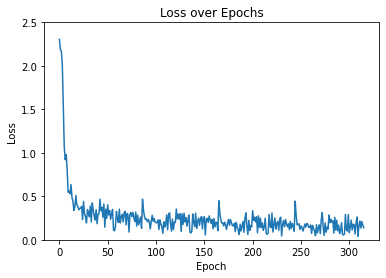

In [42]:
model = SimpleCNN()
model.load_state_dict(init_params)
model.cuda()
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05, max_iter=1, history_size=10)
loss_list_lbfgs = []
for epoch in range(4):
    for batch_idx, (x, target) in enumerate(dataloader):
        x = x.cuda()
        target = target.cuda()
        def closure():
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        loss_list_lbfgs.append(loss.item())
loss_list_lbfgs_1 = loss_list_lbfgs.copy()

plt.plot(loss_list_lbfgs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.ylim(0, 2.5)
plt.show()


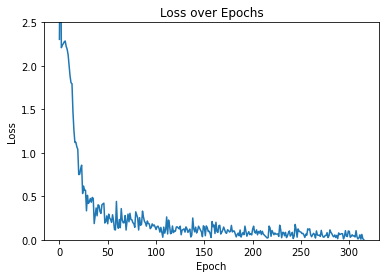

In [29]:
model = SimpleCNN()
model.load_state_dict(init_params)
model.cuda()
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_list_adam = []
for epoch in range(4):
    for batch_idx, (x, target) in enumerate(dataloader):
        x = x.cuda()
        target = target.cuda()
        def closure():
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        loss_list_adam.append(loss.item())
plt.plot(loss_list_adam)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.ylim(0, 2.5)
plt.show()


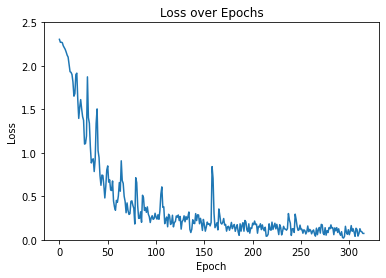

In [18]:
model = SimpleCNN()
model.load_state_dict(init_params)
model.cuda()
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_list_sgd = []
for epoch in range(4):
    for batch_idx, (x, target) in enumerate(dataloader):
        x = x.cuda()
        target = target.cuda()
        def closure():
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        loss_list_sgd.append(loss.item())
plt.plot(loss_list_sgd)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.ylim(0, 2.5)
plt.show()


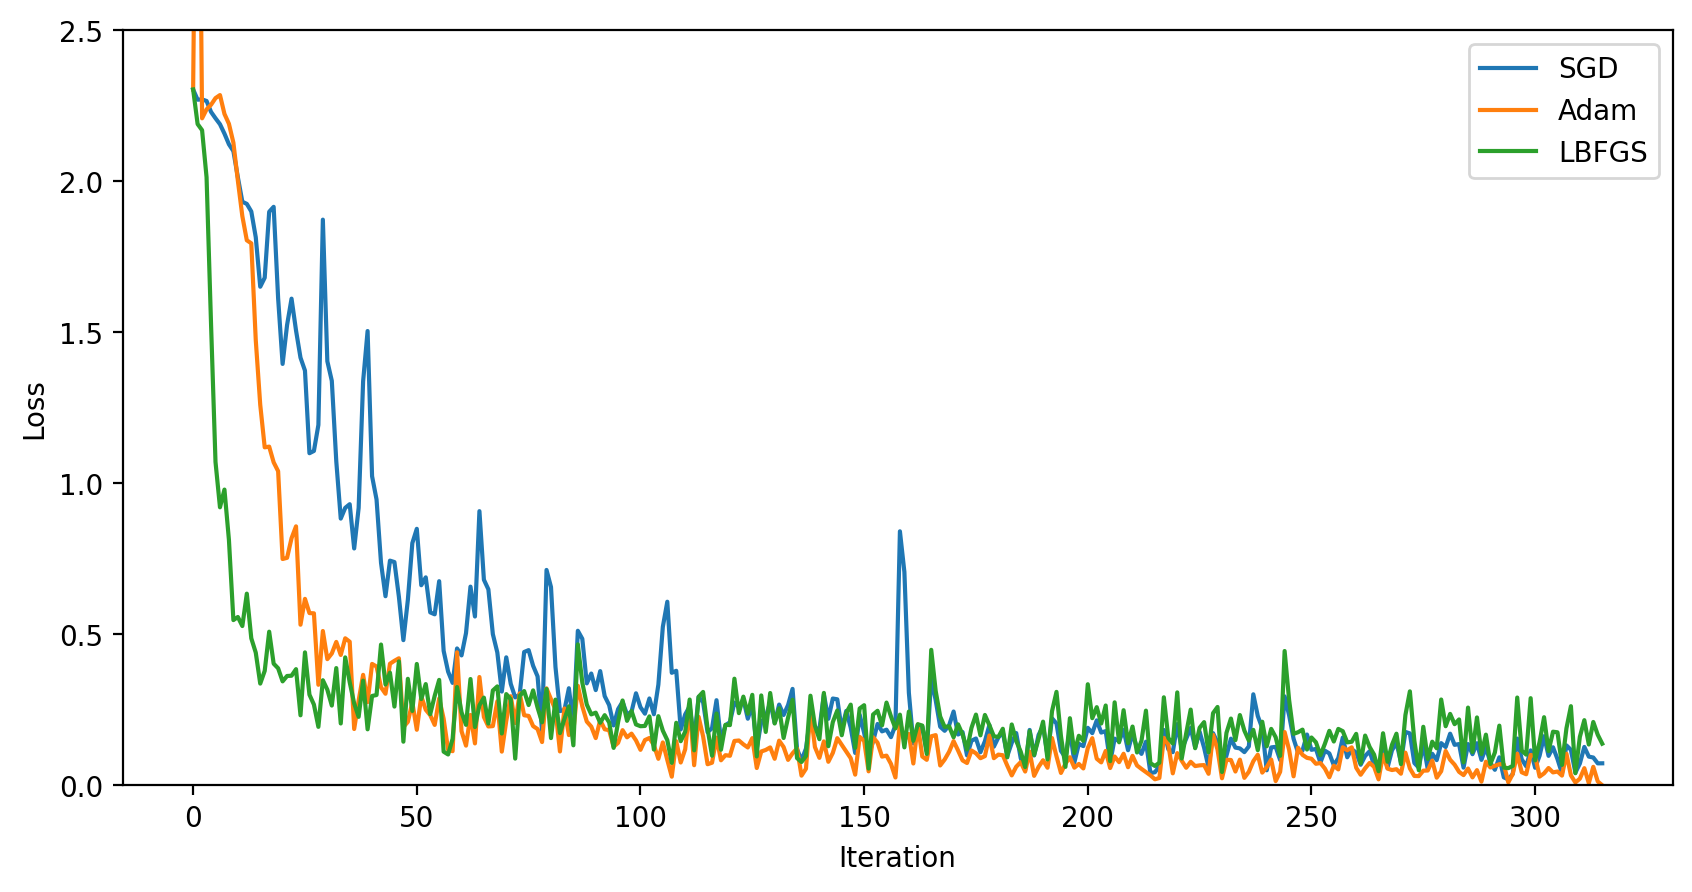

In [44]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(loss_list_sgd, label='SGD')
plt.plot(loss_list_adam, label='Adam')
plt.plot(loss_list_lbfgs_10, label='LBFGS')

plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

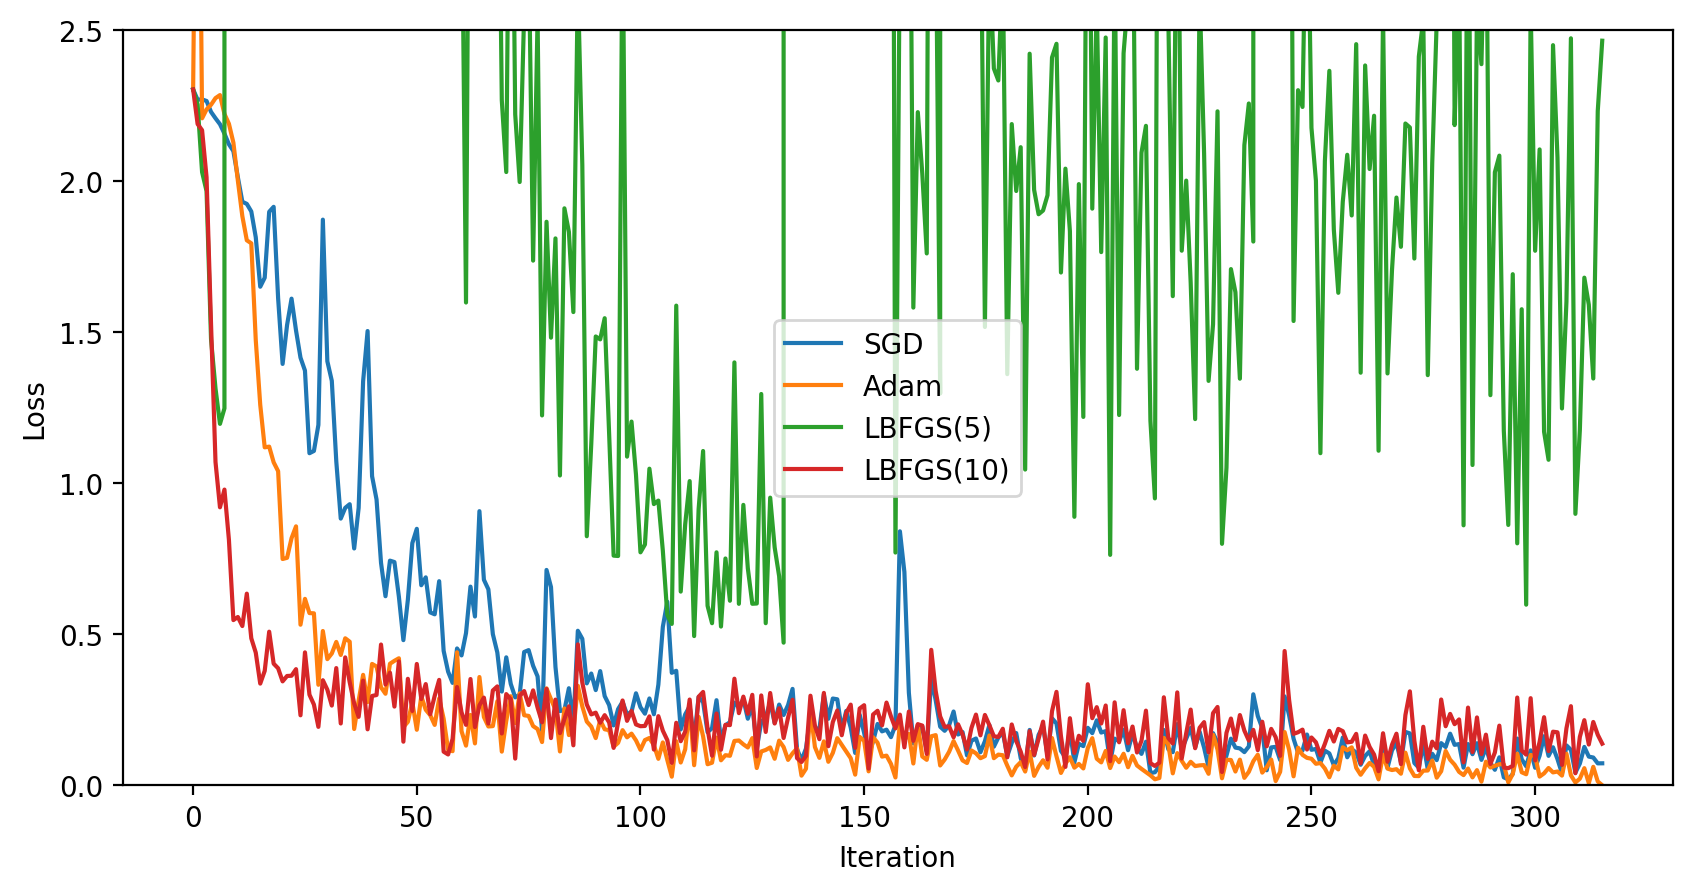

In [43]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(loss_list_sgd, label='SGD')
plt.plot(loss_list_adam, label='Adam')
plt.plot(loss_list_lbfgs_5, label='LBFGS(5)')
plt.plot(loss_list_lbfgs_10, label='LBFGS(10)')

plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

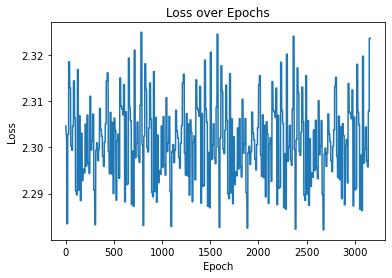

In [8]:
model = SimpleCNN()
model.load_state_dict(init_params)
model.cuda()
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = LBFGS(model.parameters(), lr=0.001)
loss_list = []
for epoch in range(4):
    for batch_idx, (x, target) in enumerate(dataloader):
        x = x.cuda()
        target = target.cuda()
        def closure():
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            return loss
        for i in range(10):
            loss = optimizer.step(closure)
            loss_list.append(loss)
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
# plt.ylim(0, 2.5)
plt.show()


## one batch

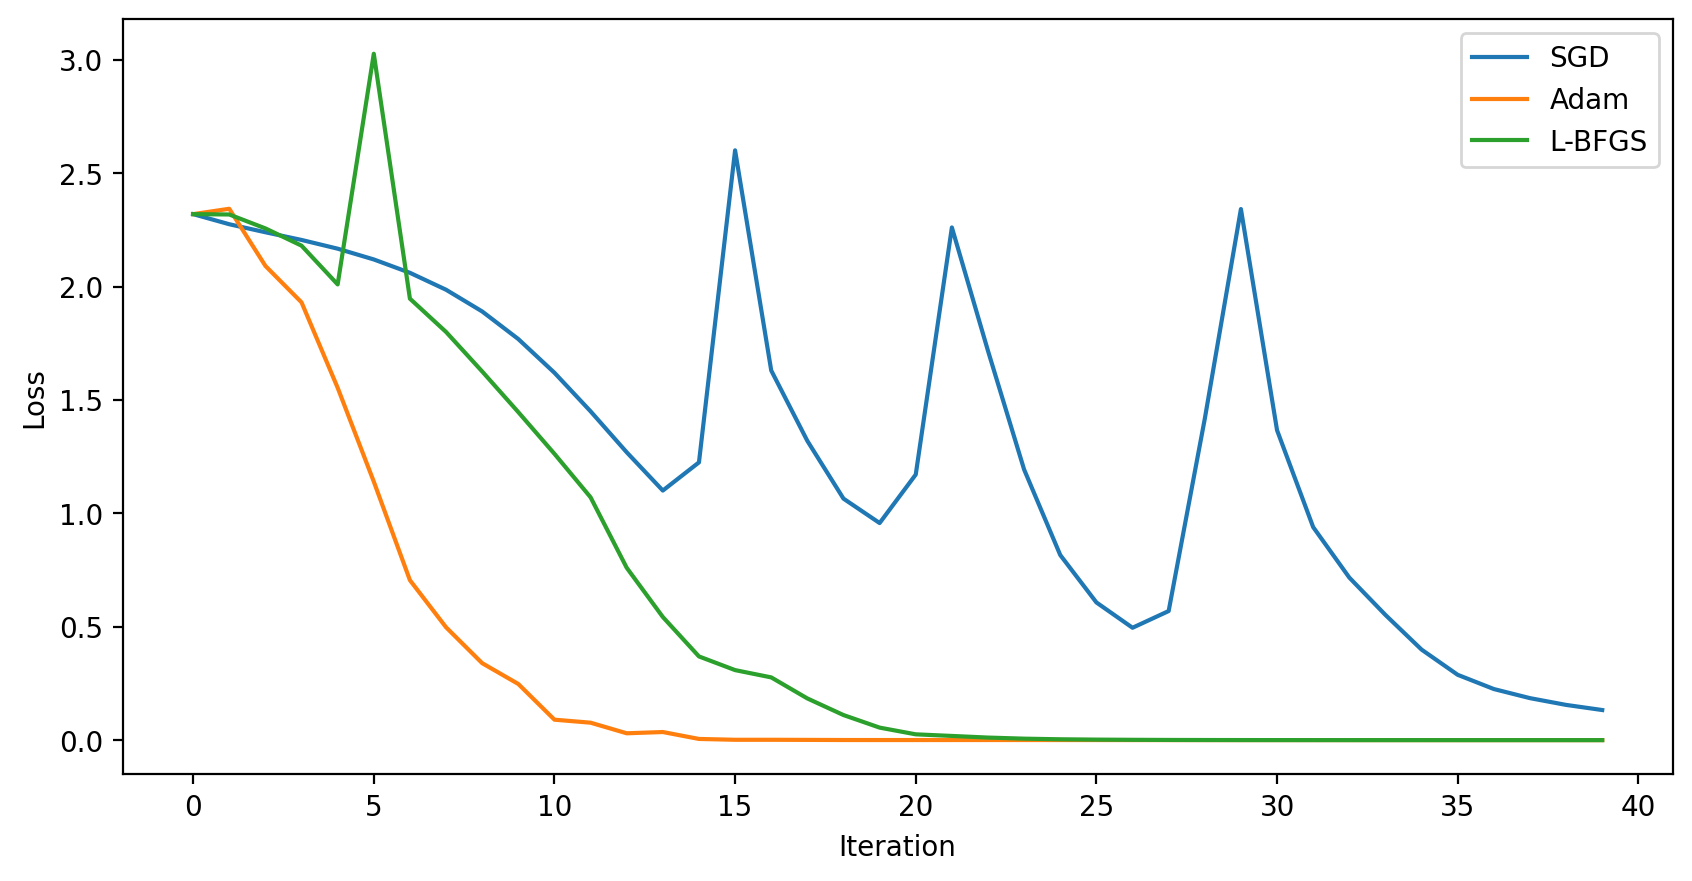

In [36]:
x,y = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=64)))
x,y = x.cuda(), y.cuda()
model = SimpleCNN()
max_iter = 40

### SGD
model.load_state_dict(init_params)
model.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0)
loss_sgd = []
for epoch in range(max_iter):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    loss_sgd.append(loss.item())

### Adam
model.load_state_dict(init_params)
model.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_adam = []
for epoch in range(max_iter):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    loss_adam.append(loss.item())

### LBFGS
model.load_state_dict(init_params)
model.cuda()
criterion = nn.CrossEntropyLoss()

# optimizer = LBFGS(model.parameters(), lr=1)
# loss_lbfgs = []
# for epoch in range(max_iter):
#     optimizer.zero_grad()
#     output = model(x)
#     loss = criterion(output, y)
#     loss.backward()
#     optimizer.step()
#     loss_lbfgs.append(loss.item())


### L-BFGS
# model.load_state_dict(init_params)
# model.cuda()
# criterion = nn.CrossEntropyLoss()

# optimizer = LBFGS(model.parameters(), lr=0.5)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.5, max_iter=max_iter)
loss_lbfgs = []
def closure():
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    loss_lbfgs.append(loss.item())
    return loss
loss = optimizer.step(closure)

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_adam, label='Adam')
plt.plot(loss_lbfgs, label='L-BFGS')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.ylim(0, 5)
plt.legend()
